#### **This notebook will compute graph-network related metrics and fit a GAMLSS model**


In [1]:
# Imports
import json
import os
import re

import colorcet as cc
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from tqdm import tqdm
from p_tqdm import p_map
import mne


from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle

In [2]:
# Set root Dir for the project.
ROOT_DIR = "/Users/anthonygagnon/Documents/École/Université/Projects/nf-pediatric/"
RESULTS_DIR = ROOT_DIR + "Connectivity/"
REPOSITORY = "/Users/anthonygagnon/code/nf-pediatric-paper/"

# Dataset folder
PING_DATA = RESULTS_DIR + "/PINGConnectivityMats/"
BCP_DATA = RESULTS_DIR + "/BCPConnectivityMats/"
BANDA_DATA = RESULTS_DIR + "/BANDAConnectivityMats/"
GESTE_DATA = RESULTS_DIR + "/GESTEConnectivityMats/"
ABCD_DATA = RESULTS_DIR + "/ABCDConnectivityMats/"
MYRNA_DATA = RESULTS_DIR + "/MYRNAConnectivityMats/"

# Create a directory for the results if it doesn't exist
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

In [3]:
# Fetch Harding font.
font_files = []
for fontpath in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Harding".lower() in fontpath.lower():
        font_files.append(fontpath)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Set Harding font.
plt.rcParams['font.family'] = 'Harding Text Web'

# Set the Set2 color palette as an iterable.
cmap = sns.color_palette("Set2", 8)

In [7]:
# Load up the data from the tar archive.
# List all .npy matrices in every dataset folder.
mats = sorted([MYRNA_DATA + f"{f}" for f in os.listdir(MYRNA_DATA) if f.endswith(".npy")])
mats += sorted([ABCD_DATA + f"{f}" for f in os.listdir(ABCD_DATA) if f.endswith(".npy")])
mats += sorted([BCP_DATA + f"{f}" for f in os.listdir(BCP_DATA) if f.endswith(".npy")])
mats += sorted([BANDA_DATA + f"{f}" for f in os.listdir(BANDA_DATA) if f.endswith(".npy")])
mats += sorted([GESTE_DATA + f"{f}" for f in os.listdir(GESTE_DATA) if f.endswith(".npy")])
mats += sorted([PING_DATA + f"{f}" for f in os.listdir(PING_DATA) if f.endswith(".npy")])

# Get subject id for each file. (we need to remove the path and the suffix)
# Each file is named like: /path/to/data/sub-XXXXX_ses-XXXX_something.npy
# We need the sub-XXXXX part and the ses-XXXX part (use regex for the session tag)
ids = []
ses = []
for mat in mats:
    ids.append(re.search(r'sub-[a-zA-Z0-9]+', mat).group(0))
    if re.search(r'ses-[a-zA-Z0-9]+', mat):
        ses.append(re.search(r'ses-[a-zA-Z0-9]+', mat).group(0))
    else:
        ses.append("")
# Alternative one-liner using list comprehension
# ids = [re.search(r'sub-[a-zA-Z0-9]+', mat) for mat in mats]

# Load everything in a dict that is tagged by subject id and session.
d = {(ids[i], ses[i]): np.load(mat) for i, mat in enumerate(mats)}
d.pop(("sub-31543", ""))
d.pop(("sub-31522", ""))
d.pop(("sub-31548", ""))
d.pop(("sub-31525", ""))
d.pop(("sub-31534", ""))
d.pop(("sub-31539", ""))
d.pop(('sub-381606', 'ses-5mo'))
d.pop(('sub-514306', 'ses-4mo'))
d.pop(('sub-758603', 'ses-13mo'))
d.pop(('sub-1357', 'ses-baseline'))
d.pop(('sub-P1429', ''))

# Do some sanity checks that all matrices have the same shape.
for id in d.keys():
    assert d[id].shape in ((227, 227), (83, 83)), f"ID {id} does not match the first matrix, shape {d[id].shape} should be either (227, 227) or (83, 83)."

# We need to normalize the matrices before computing graph metrics so that all values are between 0 and 1.
for id in d.keys():
    mat = d[id]
    # Normalize between 0 and 1.
    mat = (mat - np.min(mat)) / (np.max(mat) - np.min(mat))
    d[id] = mat

In [ ]:
# Let's build a graph for each subject and compute some metrics.
# We should do these metrics:
# - Global efficiency
# - Local efficiency
# - Strength
# - Modularity
# - Betweenness centrality
# - Rich club coefficient

def compute_graph_metrics(id_mat_tuple):
    """Compute graph metrics for a single subject."""
    id, mat = id_mat_tuple
    
    # Build graph
    G = nx.from_numpy_array(mat)
    
    # Compute metrics
    global_eff = nx.global_efficiency(G)
    local_eff = nx.local_efficiency(G)
    strength = np.mean([val for (node, val) in G.degree(weight='weight')])
    modularity = nx.algorithms.community.modularity(G, list(nx.algorithms.community.greedy_modularity_communities(G)))
    betweenness = np.mean(list(nx.betweenness_centrality(G, weight=None).values()))
    rich_club_coeff = np.mean(list(nx.rich_club_coefficient(G, normalized=False).values()))
    
    # Return metrics as a dictionary
    return {
        "subject_id": id[0],
        "session_id": id[1],
        "Density": np.sum(mat > 0) / (mat.shape[0] * (mat.shape[1])),
        "GlobalEfficiency": global_eff,
        "LocalEfficiency": local_eff,
        "AverageStrength": strength,
        "Modularity": modularity,
        "AverageBetweennessCentrality": betweenness,
        "RichClubCoefficient": rich_club_coeff
    }

# Prepare input data as list of tuples
data_to_process = [(id, mat) for id, mat in d.items()]

# Compute metrics in parallel
results = p_map(compute_graph_metrics, data_to_process, desc="Computing graph metrics", num_cpus=8)

# Convert results to dictionary format
graph_metrics = {
    "subject_id": [r["subject_id"] for r in results],
    "session_id": [r["session_id"] for r in results],
    "Density": [r["Density"] for r in results],
    "GlobalEfficiency": [r["GlobalEfficiency"] for r in results],
    "LocalEfficiency": [r["LocalEfficiency"] for r in results],
    "AverageStrength": [r["AverageStrength"] for r in results],
    "Modularity": [r["Modularity"] for r in results],
    "AverageBetweennessCentrality": [r["AverageBetweennessCentrality"] for r in results],
    "RichClubCoefficient": [r["RichClubCoefficient"] for r in results]
}

Computing graph metrics:   0%|          | 0/1789 [00:00<?, ?it/s]

In [20]:
# Fetch demo info.
myrna_demo = pd.read_csv(ROOT_DIR + "/StudyPopulation/MYRNA_demographics.csv")
myrna_demo['session_id'] = ["" for _ in range(len(myrna_demo))]
myrna_demo.rename(columns={"subject_id": "participant_id"}, inplace=True)
bcp_demo = pd.read_csv(BCP_DATA + "/participants.tsv", sep="\t")
bcp_sex = pd.read_csv(ROOT_DIR + "/StudyPopulation/BCP_demographics.csv")
geste_demo = pd.read_csv(GESTE_DATA + "/participants.tsv", sep="\t")
geste_sex = pd.read_csv(ROOT_DIR + "/StudyPopulation/GESTE_demographics.csv")
abcd_demo = pd.read_csv(ABCD_DATA + "/participants.tsv", sep="\t")
banda_demo = pd.read_csv(BANDA_DATA + "/participants.tsv", sep="\t")
ping_demo = pd.read_csv(PING_DATA + "/participants.tsv", sep="\t")
ping_demo["session_id"] = ["" for _ in range(len(ping_demo))]

# Append sex to bcp_demo by iterating over subject id and fetching the sex value in bcp_sex
for i, row in bcp_demo.iterrows():
    subject_id = row['participant_id']
    sex = bcp_sex.loc[bcp_sex['subject_id'] == subject_id, 'sex'].values
    if len(sex) > 0:
        bcp_demo.at[i, 'sex'] = sex[0]

# Same thing for GESTE
for i, row in geste_demo.iterrows():
    subject_id = row['participant_id']
    sex = geste_sex.loc[geste_sex['subject_id'] == subject_id, 'sex'].values
    if len(sex) > 0:
        geste_demo.at[i, 'sex'] = sex[0]

# Reorder all columns in demographics dataframes to have subject_id, session_id, sex, age, and cohort (append cohort if not present)
df = [myrna_demo, bcp_demo, geste_demo, abcd_demo, banda_demo, ping_demo]
for i in range(len(df)):
    if 'cohort' not in df[i].columns:
        df[i]['cohort'] = ['MYRNA', 'BCP', 'GESTE', 'ABCD', 'BANDA', 'PING'][i]
    cols = ['participant_id', 'session_id', 'sex', 'age', 'cohort']
    df[i] = df[i][cols]

# Concatenate all demographics dataframes
demographics = pd.concat(df, ignore_index=True)

# Let's create a dataframe from the graph metrics dictionary.
graph_metrics_df = pd.DataFrame(graph_metrics)
graph_metrics_df.rename(columns={"subject_id": "participant_id"}, inplace=True)

# Merge with demographics
graph_metrics_df = graph_metrics_df.merge(demographics, left_on=["participant_id", "session_id"], right_on=["participant_id", "session_id"])

# Drop rows with NaN in 'age' or 'sex' columns.
print( graph_metrics_df[['age', 'sex']].isna().sum() )
graph_metrics_df = graph_metrics_df.dropna(subset=['age', 'sex'])

# Save the graph metrics to a CSV file.
graph_metrics_df.to_csv(RESULTS_DIR + "graph_metrics.csv", index=False)

age     0
sex    18
dtype: int64


In [6]:
# Call the python script to fit GAMLSS models
!python ../scripts/networkGAMLSS.py \
    "{RESULTS_DIR}/graph_metrics.csv" \
    "{RESULTS_DIR}/GAMLSS_Models/" \
    --metric Density GlobalEfficiency LocalEfficiency Modularity AverageBetweennessCentrality \
    --rscript "{REPOSITORY}/scripts/gamlss.R" \
    --log_age \
    --n_cpus 6 \
    -f

#### **Let's do some visualization of frequency of connections for a few bins**

In [5]:
# Load up the data.
graph_metrics_df = pd.read_csv(f"{RESULTS_DIR}/graph_metrics.csv")

In [6]:
# Using the dataframe, we need to create 6 bins: 0-0.25, 0.25-1, 1-2, 2-5, 5-10, 10-18.
# For each bin, create lists of tuple(subject_id, session_id) to process further.
graph_metrics_df['age_bin'] = pd.cut(graph_metrics_df['age'], bins=[0, 0.25, 1, 2, 5, 10, 18], labels=['0-0.25', '0.25-1', '1-2', '2-5', '5-10', '10-18'])

# Manually fix sub-31188 from bin 0.25-1 to 0-0.25
graph_metrics_df.loc[graph_metrics_df['participant_id'] == 'sub-31188', 'age_bin'] = '0-0.25'

# Create lists of tuples for each bin
age_bins = {}
for bin_label in graph_metrics_df['age_bin'].unique():
    bin_df = graph_metrics_df[graph_metrics_df['age_bin'] == bin_label]
    age_bins[bin_label] = list(zip(bin_df['participant_id'], bin_df['session_id']))

# We need some assertions here, using the original dict 'd', that all subject in the 0-0.25 bin have matrices of shape (83, 83)
# and all remaining subjects have matrices of shape (227, 227).
for participant_id, session_id in age_bins['0-0.25']:
    assert d[(participant_id, session_id if pd.notna(session_id) else "")].shape == (83, 83), f"Subject {participant_id} in bin 0-0.25 does not have matrix shape (83, 83)."
for bin_label in ['0.25-1', '1-2', '2-5', '5-10', '10-18']:
    for participant_id, session_id in age_bins[bin_label]:
        assert d[(participant_id, session_id if pd.notna(session_id) else "")].shape == (227, 227), f"Subject {participant_id} in bin {bin_label} does not have matrix shape (227, 227)."

In [7]:
# For each bin, let's compute the frequency of each connection using bootstrapping.
# Resample each bin to the smallest bin size to equalize statistical power.

# Find the minimum bin size
min_bin_size = min(len(age_bins[bin]) for bin in age_bins.keys())
print(f"Minimum bin size: {min_bin_size}")
print(f"Bin sizes: {[(bin, len(age_bins[bin])) for bin in age_bins.keys()]}")

# Number of bootstrap iterations
n_bootstrap = 1000
print(f"Running {n_bootstrap} bootstrap iterations...")

# Preset keys in output dict. (83, 83) for 0-0.25, (227, 227) for the rest.
freq_mat = {}
freq_mat['0-0.25'] = np.zeros((83, 83))
for bin_label in ['0.25-1', '1-2', '2-5', '5-10', '10-18']:
    freq_mat[bin_label] = np.zeros((227, 227))

for bin in age_bins.keys():
    print(f"Processing bin {bin}...")
    
    # Initialize accumulator for bootstrap samples
    bootstrap_sum = np.zeros_like(freq_mat[bin])
    
    # Get the subjects in this bin
    bin_subjects = age_bins[bin]
    
    # Perform bootstrap resampling
    for boot_iter in tqdm(range(n_bootstrap)):
        # Randomly sample min_bin_size subjects with replacement
        sampled_subjects = np.random.choice(len(bin_subjects), size=min_bin_size, replace=True)
        
        # Compute frequency for this bootstrap sample
        boot_freq = np.zeros_like(freq_mat[bin])
        for idx in sampled_subjects:
            sub, ses = bin_subjects[idx]
            boot_freq += np.where(d[(sub, ses if pd.notna(ses) else "")] > 0, 1, 0)
        
        # Convert to percentage for this bootstrap sample
        boot_freq = (boot_freq / min_bin_size) * 100
        
        # Add to accumulator
        bootstrap_sum += boot_freq
    
    # Average across all bootstrap iterations
    freq_mat[bin] = bootstrap_sum / n_bootstrap
    
    print(f"  Bin {bin}: mean frequency = {freq_mat[bin].mean():.2f}%, max = {freq_mat[bin].max():.2f}%")

print("Bootstrap resampling complete!")


Minimum bin size: 113
Bin sizes: [('0-0.25', 113), ('10-18', 768), ('5-10', 386), ('0.25-1', 196), ('1-2', 189), ('2-5', 114)]
Running 1000 bootstrap iterations...
Processing bin 0-0.25...


100%|██████████| 1000/1000 [00:01<00:00, 685.59it/s]


  Bin 0-0.25: mean frequency = 42.95%, max = 100.00%
Processing bin 10-18...


100%|██████████| 1000/1000 [00:07<00:00, 140.70it/s]


  Bin 10-18: mean frequency = 23.64%, max = 100.00%
Processing bin 5-10...


100%|██████████| 1000/1000 [00:06<00:00, 142.91it/s]


  Bin 5-10: mean frequency = 22.51%, max = 100.00%
Processing bin 0.25-1...


100%|██████████| 1000/1000 [00:06<00:00, 144.13it/s]


  Bin 0.25-1: mean frequency = 33.54%, max = 100.00%
Processing bin 1-2...


100%|██████████| 1000/1000 [00:06<00:00, 145.36it/s]


  Bin 1-2: mean frequency = 35.83%, max = 100.00%
Processing bin 2-5...


100%|██████████| 1000/1000 [00:06<00:00, 146.38it/s]

  Bin 2-5: mean frequency = 27.89%, max = 100.00%
Bootstrap resampling complete!


In [8]:
# We need to fetch the labels for the nodes. Let's try first with the Brainnetome (227 nodes)

with open(RESULTS_DIR + "atlas_brainnetome_child_v1_LUT.json", 'r') as f:
    brainnetome_labels = json.load(f)

# Load the LUT file to get colors for each region
lut_file = RESULTS_DIR + "atlas_brainnetome_child_v1_LUT.txt"
names = []
node_colors_rgb = []

with open(lut_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 5 and parts[0] != '0':  # Skip background (index 0)
            idx = int(parts[0])
            region_name = parts[1]
            r, g, b = int(parts[2]), int(parts[3]), int(parts[4])
            
            names.append(region_name)
            # Normalize RGB values to 0-1 range for matplotlib
            node_colors_rgb.append((r/255.0, g/255.0, b/255.0))

# Verify we have 227 regions
assert len(names) == 227, f"Expected 227 regions, got {len(names)}"
assert len(node_colors_rgb) == 227, f"Expected 227 colors, got {len(node_colors_rgb)}"

print(f"Loaded {len(names)} regions with their associated colors")
print(f"Example regions: {names[:5]}")
print(f"Example colors (RGB): {node_colors_rgb[:5]}")

# Split into left and right hemispheres based on naming convention
left_idxs = []
right_idxs = []
bottom_idxs = []
brainstem_idxs = []
cerebellum_left_idxs = []
cerebellum_right_idxs = []

for i, name in enumerate(names):
    parts = name.split('_')
    if len(parts) >= 2:
        # The second element is typically 'L' or 'R'
        if parts[1] == 'L':
            left_idxs.append(i)
        elif parts[1] == 'R':
            right_idxs.append(i)
        else:
            if 'left' in name.lower():
                cerebellum_left_idxs.append(i)
            elif 'right' in name.lower():
                cerebellum_right_idxs.append(i)
            else:
                # No clear hemisphere designation
                brainstem_idxs.append(i)
    else:
        # Short names without clear hemisphere
        brainstem_idxs.append(i)

bottom_idxs = cerebellum_left_idxs + brainstem_idxs + cerebellum_right_idxs

print(f"Left hemisphere regions: {len(left_idxs)}")
print(f"Right hemisphere regions: {len(right_idxs)}")
print(f"Brainstem regions: {len(brainstem_idxs)}")
print(f"Cerebellum left regions: {len(cerebellum_left_idxs)}")
print(f"Cerebellum right regions: {len(cerebellum_right_idxs)}")
print(f"Bottom regions (cerebellum/brainstem): {len(bottom_idxs)}")
print(f"Total: {len(left_idxs) + len(right_idxs) + len(bottom_idxs)}")


Loaded 227 regions with their associated colors
Example regions: ['SFG_L_6_1', 'SFG_R_6_1', 'SFG_L_6_2', 'SFG_R_6_2', 'SFG_L_6_3']
Example colors (RGB): [(0.0, 1.0, 0.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.0), (0.0, 0.9647058823529412, 1.0), (1.0, 0.4823529411764706, 0.8627450980392157)]
Left hemisphere regions: 112
Right hemisphere regions: 112
Brainstem regions: 1
Cerebellum left regions: 1
Cerebellum right regions: 1
Bottom regions (cerebellum/brainstem): 3
Total: 227


In [124]:
broad_labels = {
    "SFG": ["SFG*"],
    "MFG": ["MFG*"],
    "IFG": ["IFG*"],
    "OrG": ["OrG*"],
    "PrG": ["PrG*"],
    "PCL": ["PCL*"],
    "STG": ["STG*"],
    "MTG": ["MTG*"],
    "ITG": ["ITG*"],
    "FuG": ["FuG*"],
    "PhG": ["PhG*"],
    "pSTS": ["pSTS*"],
    "SPL": ["SPL*"],
    "IPL": ["IPL*"],
    "PCun": ["PCun*"],
    "PoG": ["PoG*"],
    "INS": ["INS*"],
    "CG": ["CG*"],
    "MVOcC": ["MVOcC*"],
    "LOcC": ["LOcC*"],
    "Subcortical": ["*Amyg*", "*Hipp*", "*Ca*", "*GP*", "*NAC*", "*Pu*", "*tha*"],
    "BS/Cerebellum": ["*cerebellum*", "*brainstem*"]
}

broad_labels_idxs = {key: [] for key in broad_labels.keys()}
for i, name in enumerate(names):
    for broad_label, patterns in broad_labels.items():
        for pattern in patterns:
            if re.match(pattern.replace("*", ".*"), name):
                broad_labels_idxs[broad_label].append(i)
                break
print("Broad labels and their region counts:")
for key, idxs in broad_labels_idxs.items():
    print(f"{key}: {len(idxs)} regions")

# Assert that the total number of regions in broad_labels_idxs matches 227
total_broad_regions = sum(len(idxs) for idxs in broad_labels_idxs.values())
assert total_broad_regions == 227, f"Expected 227 regions in broad labels, got {total_broad_regions}"

Broad labels and their region counts:
SFG: 12 regions
MFG: 14 regions
IFG: 12 regions
OrG: 12 regions
PrG: 12 regions
PCL: 4 regions
STG: 12 regions
MTG: 8 regions
ITG: 10 regions
FuG: 6 regions
PhG: 12 regions
pSTS: 4 regions
SPL: 8 regions
IPL: 12 regions
PCun: 8 regions
PoG: 8 regions
INS: 6 regions
CG: 10 regions
MVOcC: 10 regions
LOcC: 8 regions
Subcortical: 36 regions
BS/Cerebellum: 3 regions


Number of connections over 90% in age bin 0.25-1: 5150
Assigned 1 unique colors to 22 broader labels
Number of broader label groups: 43
Groups: ['SFG', 'MFG', 'IFG', 'OrG', 'PrG', 'PCL', 'STG', 'MTG', 'ITG', 'FuG', 'PhG', 'pSTS', 'SPL', 'IPL', 'PCun', 'PoG', 'INS', 'CG', 'MVOcC', 'LOcC', 'Subcortical', 'BS/Cerebellum', 'Subcortical', 'LOcC', 'MVOcC', 'CG', 'INS', 'PoG', 'PCun', 'IPL', 'SPL', 'pSTS', 'PhG', 'FuG', 'ITG', 'MTG', 'STG', 'PCL', 'PrG', 'OrG', 'IFG', 'MFG', 'SFG']
Number of connections over 90% in age bin 1-2: 6254
Assigned 1 unique colors to 22 broader labels
Number of broader label groups: 43
Groups: ['SFG', 'MFG', 'IFG', 'OrG', 'PrG', 'PCL', 'STG', 'MTG', 'ITG', 'FuG', 'PhG', 'pSTS', 'SPL', 'IPL', 'PCun', 'PoG', 'INS', 'CG', 'MVOcC', 'LOcC', 'Subcortical', 'BS/Cerebellum', 'Subcortical', 'LOcC', 'MVOcC', 'CG', 'INS', 'PoG', 'PCun', 'IPL', 'SPL', 'pSTS', 'PhG', 'FuG', 'ITG', 'MTG', 'STG', 'PCL', 'PrG', 'OrG', 'IFG', 'MFG', 'SFG']
Number of connections over 90% in age bin 1

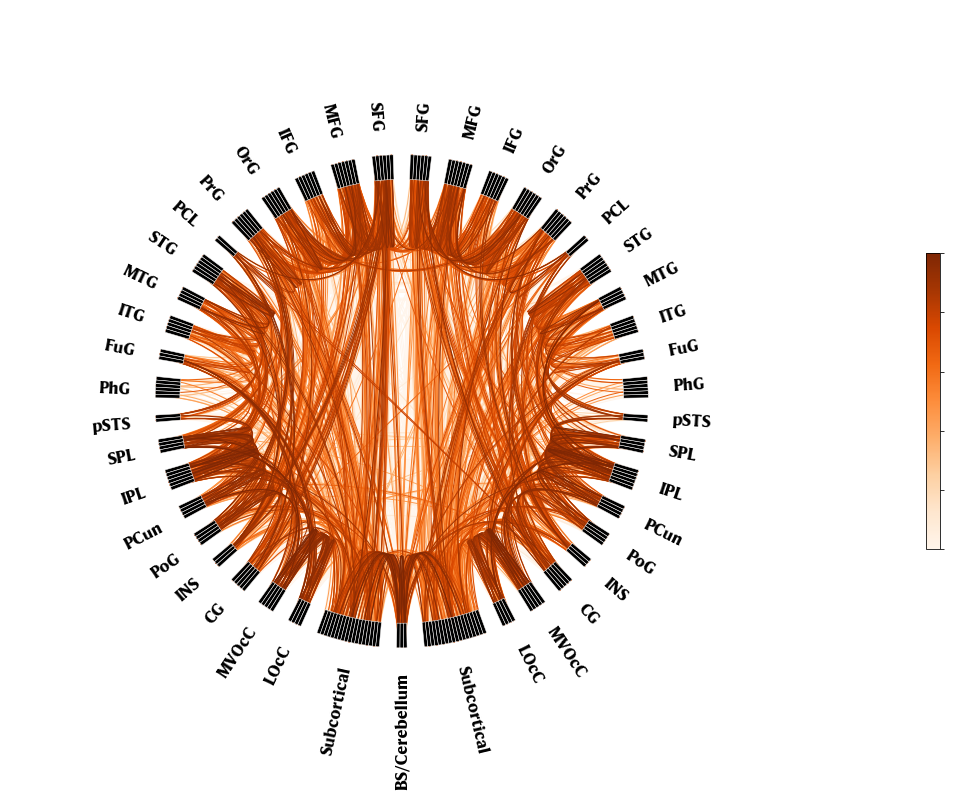

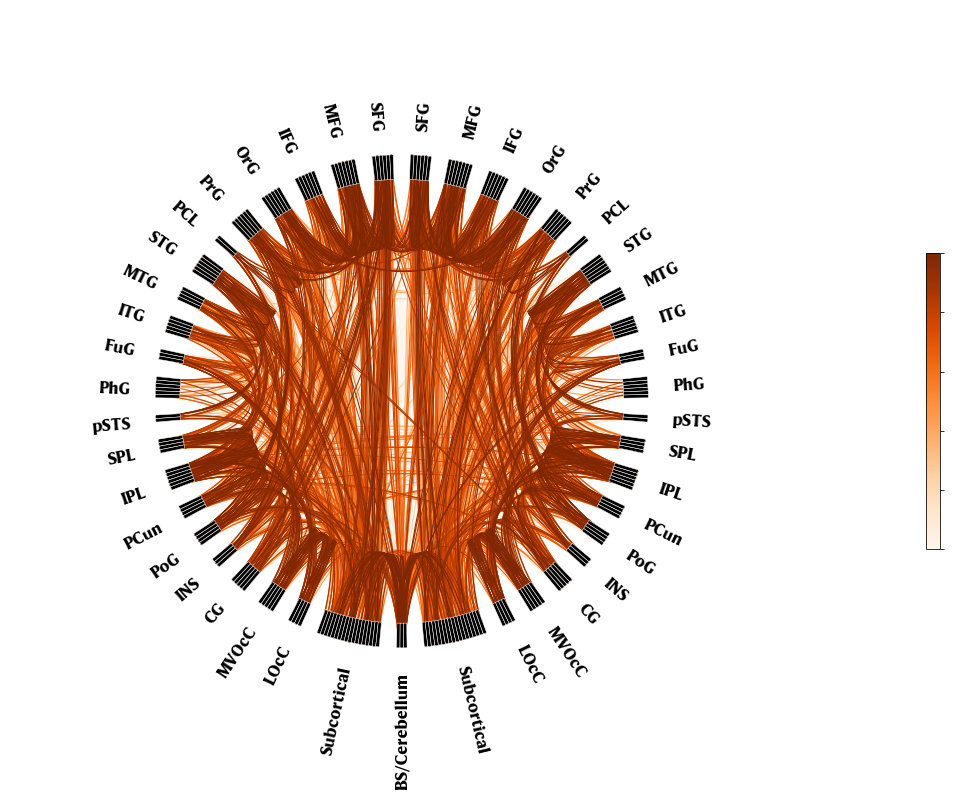

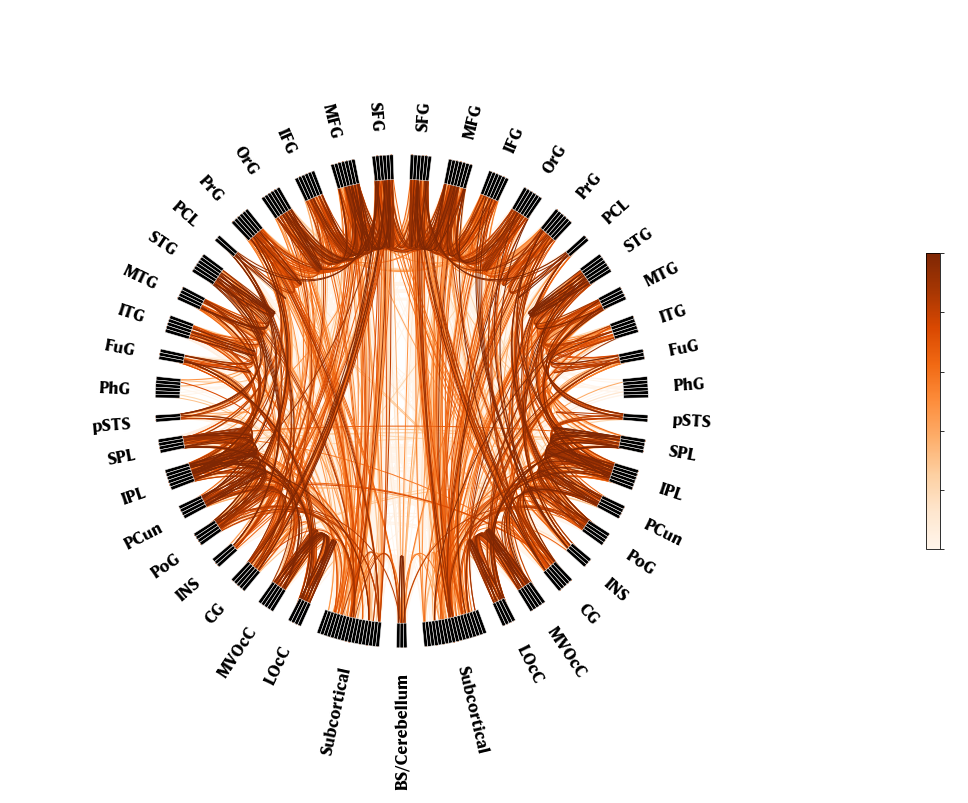

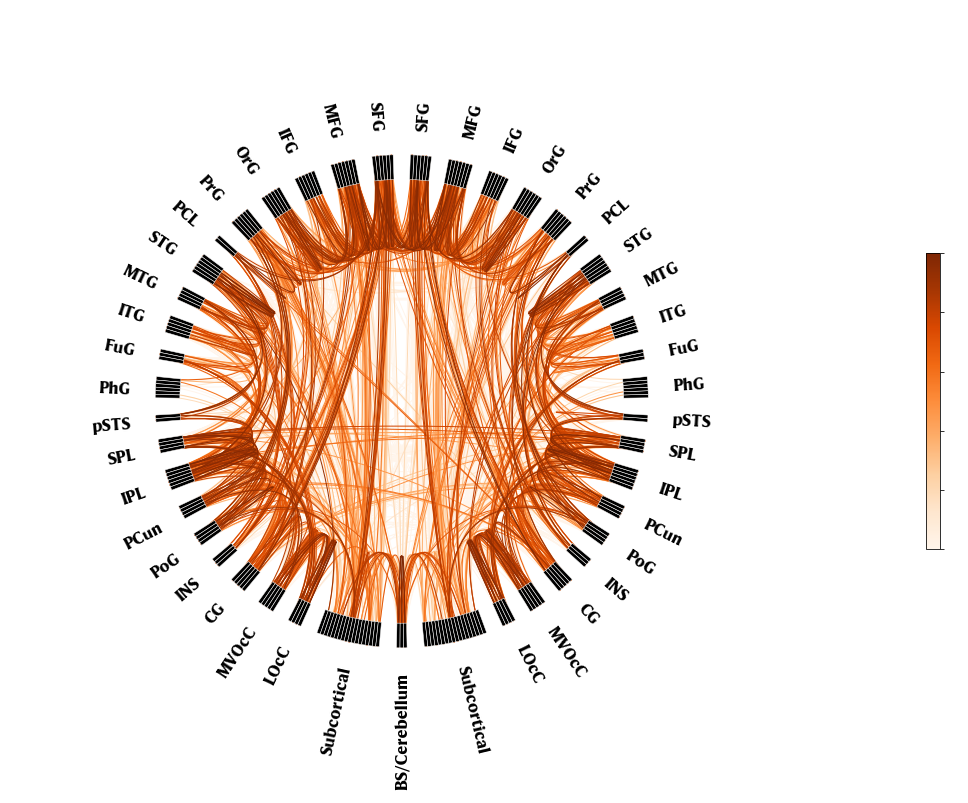

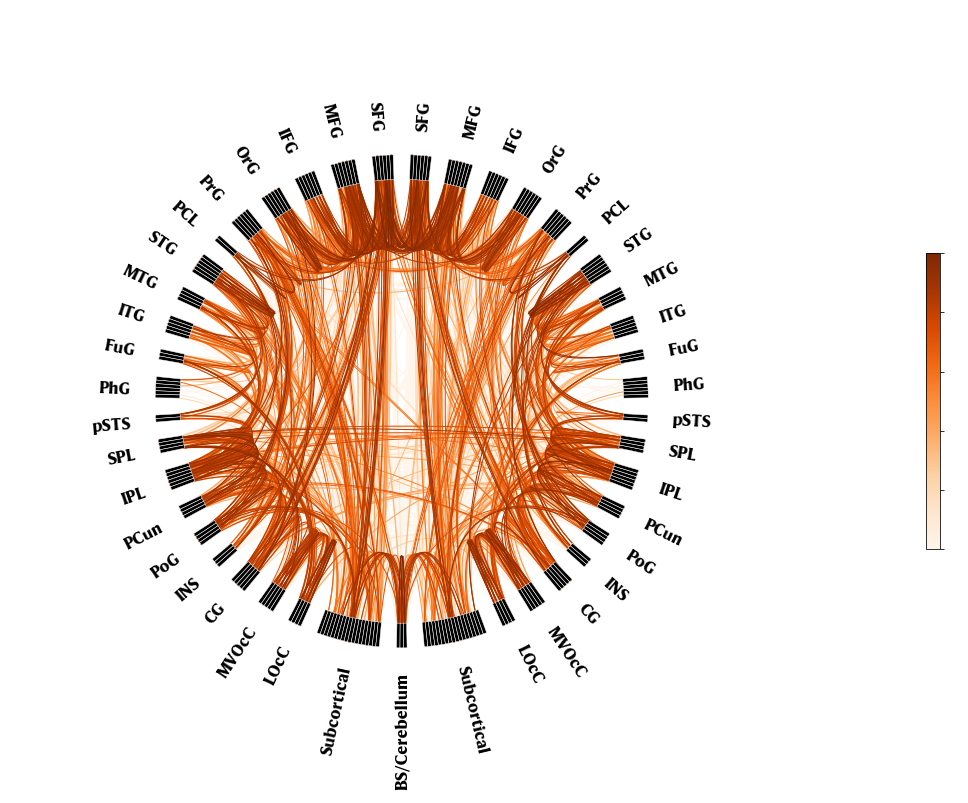

In [125]:
# Loop over bins with brainnetome atlas
bn_bins = ['0.25-1', '1-2', '2-5', '5-10', '10-18']

for b in bn_bins:
    # Select which age bin to visualize (e.g., '2-5' years)
    selected_bin = b

    # Get the frequency matrix for the selected bin
    freq_matrix = freq_mat[selected_bin]
    # Reorder nodes: left hemisphere, bottom group, right hemisphere
    # Reverse right hemisphere for better circular layout
    right_idxs_reversed = right_idxs[::-1]
    order = left_idxs + bottom_idxs + right_idxs_reversed

    # Reorder connectivity matrix and labels
    conn = freq_matrix[np.ix_(order, order)]
    node_names = [names[i] for i in order]

    # Count the amount of nodes that have values over 80%
    high_value_count = np.sum(conn > 90)
    print(f"Number of connections over 90% in age bin {selected_bin}: {high_value_count}")

    # Create a mapping from each node to its broader label using the broad_labels dictionary
    node_to_broad_label = {}
    for i, name in enumerate(names):
        for broad_label, patterns in broad_labels.items():
            for pattern in patterns:
                if re.match(pattern.replace("*", ".*"), name):
                    node_to_broad_label[name] = broad_label
                    break
            if name in node_to_broad_label:
                break

    # Assign a unique color to each broader label
    unique_broad_labels = list(broad_labels.keys())
    n_labels = len(unique_broad_labels)

    # Use a colormap to generate distinct colors for each broader label
    broad_label_colormap = sns.color_palette(cc.glasbey_warm, n_colors=n_labels)
    broad_label_colors = {label: broad_label_colormap[i] for i, label in enumerate(unique_broad_labels)}

    # Assign colors to nodes based on their broader label
    node_colors = []
    for i in order:
        name = names[i]
        broad_label = node_to_broad_label.get(name, None)
        if broad_label:
            node_colors.append("black")
        else:
            # Fallback color if no broad label found
            node_colors.append((0.5, 0.5, 0.5))

    print(f"Assigned {len(set(node_colors))} unique colors to {len(unique_broad_labels)} broader labels")

    # Find boundaries between different broader label groups for padding
    broad_label_boundaries = [0]
    group_labels = []
    group_ranges = []
    current_broad_label = None
    start_idx = 0

    for i, name in enumerate(node_names):
        broad_label = node_to_broad_label.get(name, name.split('_')[0])
        if broad_label != current_broad_label:
            if i > 0:
                broad_label_boundaries.append(i)
                # Save the previous group
                group_labels.append(current_broad_label)
                group_ranges.append((start_idx, i))
            current_broad_label = broad_label
            start_idx = i

    # Don't forget the last group
    if current_broad_label is not None:
        group_labels.append(current_broad_label)
        group_ranges.append((start_idx, len(node_names)))

    print(f"Number of broader label groups: {len(group_labels)}")
    print(f"Groups: {group_labels}")

    # Compute node angles for circular layout with padding between broader label groups
    node_angles = circular_layout(node_names, node_names, 
                                start_pos=90, start_between=True, 
                                group_boundaries=broad_label_boundaries,
                                group_sep=4)  # Add 3 degrees padding between each broader label group

    # Create the chord diagram with larger circle
    fig, ax = plt.subplots(figsize=(14, 14), facecolor="white", subplot_kw=dict(polar=True))

    # Set radial limits to make circle larger
    ax.set_ylim(0, 10)

    plot_connectivity_circle(conn, node_names,
                            node_angles=node_angles,
                            node_colors=node_colors,
                            colormap="Oranges",  # Color scheme for connections
                            facecolor="white",
                            textcolor="white",
                            linewidth=1,
                            n_lines=high_value_count,
                            node_linewidth=0.5,
                            #node_width=10,
                            node_edgecolor="white",
                            fontsize_names=0,
                            vmin=90,
                            vmax=conn.max(),
                            colorbar_size=0.3,
                            colorbar_pos=(0.6, 0.5),
                            ax=ax,
                            show=False)

    # Add broader group labels pointing outwards
    for label, (start, end) in zip(group_labels, group_ranges):
        # Calculate the middle angle for this group
        middle_idx = (start + end) // 2
        angle = node_angles[middle_idx]
        
        # Convert angle to radians
        angle_rad = np.deg2rad(angle)
        
        # Position text outside the circle
        radius = 11
        
        # Determine text rotation and alignment for outward-pointing labels
        rotation = angle
        if 90 < angle < 270:
            # Bottom half - rotate 180 degrees so text reads outward
            rotation = angle - 180
            ha = 'right'
        else:
            # Top half - keep as is
            ha = 'left'
        
        ax.text(angle_rad, radius, label, 
                rotation=rotation, rotation_mode='anchor',
                ha=ha, va='center_baseline', fontsize=16, fontweight='bold')

    # Remove tick marks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    fig.savefig(RESULTS_DIR + f"chord_chart_brainnetome_{selected_bin.replace('-', '_')}.png", 
                dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')


In [14]:
# Let's do the same but for the 0-0.25 bin with the Desiakn-Killiany atlas (83 nodes)
# Load the Desikan-Killiany labels
with open(RESULTS_DIR + "atlas_freesurfer_v5_LUT_interleaved.json") as f:
    desikan_labels = json.load(f)

# No need for colors, since we use black.
# Just get the indices for the left hemisphere, right hemisphere, and bottom group (brainstem/cerebellum)
left_idxs_dk = []
right_idxs_dk = []
bottom_idxs_dk = []
brainstem_idxs_dk = []
cerebellum_left_idxs_dk = []
cerebellum_right_idxs_dk = []

# Naming is left_* or right_*
for i, name in enumerate(desikan_labels.values()):
    parts = name.split('_')
    if parts[0] == 'left' and i < 81:
        left_idxs_dk.append(i)
    elif parts[0] == 'right' and i < 81:
        right_idxs_dk.append(i)
    else:
        if 'cerebellum' in name.lower() and 'left' in name.lower():
            cerebellum_left_idxs_dk.append(i)
        elif 'cerebellum' in name.lower() and 'right' in name.lower():
            cerebellum_right_idxs_dk.append(i)
        else:
            # No clear hemisphere designation (brainstem)
            brainstem_idxs_dk.append(i)

bottom_idxs_dk = cerebellum_left_idxs_dk + brainstem_idxs_dk + cerebellum_right_idxs_dk
print(f"Desikan-Killiany Left hemisphere regions: {len(left_idxs_dk)}")
print(f"Desikan-Killiany Right hemisphere regions: {len(right_idxs_dk)}")
print(f"Desikan-Killiany Brainstem regions: {len(brainstem_idxs_dk)}")
print(f"Desikan-Killiany Cerebellum left regions: {len(cerebellum_left_idxs_dk)}")
print(f"Desikan-Killiany Cerebellum right regions: {len(cerebellum_right_idxs_dk)}")
print(f"Desikan-Killiany Bottom regions (cerebellum/brainstem): {len(bottom_idxs_dk)}")
print(f"Desikan-Killiany Total: {len(left_idxs_dk) + len(right_idxs_dk) + len(bottom_idxs_dk)}")
assert len(left_idxs_dk) + len(right_idxs_dk) + len(bottom_idxs_dk) == 83, "Total regions do not sum to 83!"

# We need a new names list for Desikan-Killiany to be used in future broad labels.
dk_names = list(desikan_labels.values())

Desikan-Killiany Left hemisphere regions: 40
Desikan-Killiany Right hemisphere regions: 40
Desikan-Killiany Brainstem regions: 1
Desikan-Killiany Cerebellum left regions: 1
Desikan-Killiany Cerebellum right regions: 1
Desikan-Killiany Bottom regions (cerebellum/brainstem): 3
Desikan-Killiany Total: 83


In [15]:
broad_labels_dk = {
    "FL": ["*superior_frontal*", "*middle_frontal*", "*parsopercularis*", "*parstriangularis*", "*parsorbitalis*", "*orbitofrontal*",
           "*frontal_pole*", "*precentral*", "*paracentral*"],
    "PL": ["*postcentral*", "*supra_marginal*", "*superior_parietal*", "*inferior_parietal*", "*precuneus*"],
    "LTL": ["*superior_temporal*", "*middle_temporal*", "*inferior_temporal*", "*transverse_temporal*", "banks*"],
    "MTL": ["*entorhinal*", "*parahippocampal*", "*fusiform*", "*temporal_pole*", "*insula*"],
    "OL": ["*cuneus*", "*pericalcarine*", "*lateral_occipital*", "*lingual*"],
    "Cingulate": ["*cingulate*"],
    "Subcortical": ["*amygdala*", "*hippocampus*", "*caudate*", "*putamen*", "*pallidum*", "*thalamus*"],
    "BS/Cerebellum": ["*cerebellum*", "*brainstem*"]
}

broad_labels_dk_idxs = {key: [] for key in broad_labels_dk.keys()}
for i, name in enumerate(dk_names):
    assigned = False
    for broad_label, patterns in broad_labels_dk.items():
        if assigned:
            break
        for pattern in patterns:
            if re.match(pattern.replace("*", ".*"), name):
                broad_labels_dk_idxs[broad_label].append(i)
                assigned = True
                break

print("Broad labels and their region counts:")
for key, idxs in broad_labels_dk_idxs.items():
    print(f"{key}: {len(idxs)} regions")

# Assert that the total number of regions in broad_labels_dk_idxs matches 83
total_broad_regions = sum(len(idxs) for idxs in broad_labels_dk_idxs.values())
print(f"Total regions assigned: {total_broad_regions}")
assert total_broad_regions == 83, f"Expected 83 regions in broad labels, got {total_broad_regions}"

Broad labels and their region counts:
FL: 22 regions
PL: 10 regions
LTL: 10 regions
MTL: 10 regions
OL: 8 regions
Cingulate: 8 regions
Subcortical: 12 regions
BS/Cerebellum: 3 regions
Total regions assigned: 83


In [16]:
# Let's take the previously ordered indices in left, right, bottom idxs and reorder them so that
# FL, PL, LTL, MTL, OL, Cingulate, Subcortical, BS/Cerebellum are grouped together in that specific order (while
# maintaining left-right hemisphere and bottom grouping).
broad_label_order = ["FL", "PL", "LTL", "MTL", "OL", "Cingulate", "Subcortical", "BS/Cerebellum"]
ordered_idxs_dk = []
for broad_label in broad_label_order:
    idxs = broad_labels_dk_idxs[broad_label]
    # Split into left, right, bottom
    left = [i for i in idxs if i in left_idxs_dk]
    right = [i for i in idxs if i in right_idxs_dk]
    bottom = [i for i in idxs if i in bottom_idxs_dk]
    ordered_idxs_dk.extend(left + bottom + right)
print(f"Total ordered indices for Desikan-Killiany: {len(ordered_idxs_dk)}")
assert len(ordered_idxs_dk) == 83, "Ordered indices do not sum to 83!"

Total ordered indices for Desikan-Killiany: 83


Bottom region order (3 regions):
  0: left_cerebellum_cortex
  1: brainstem
  2: right_cerebellum_cortex
Number of connections over 90% in age bin 0-0.25: 1214
Assigned 1 unique color to 83 nodes
Number of broader label groups: 15
Groups: ['FL', 'PL', 'LTL', 'MTL', 'OL', 'Cingulate', 'Subcortical', 'BS/Cerebellum', 'Subcortical', 'Cingulate', 'OL', 'MTL', 'LTL', 'PL', 'FL']


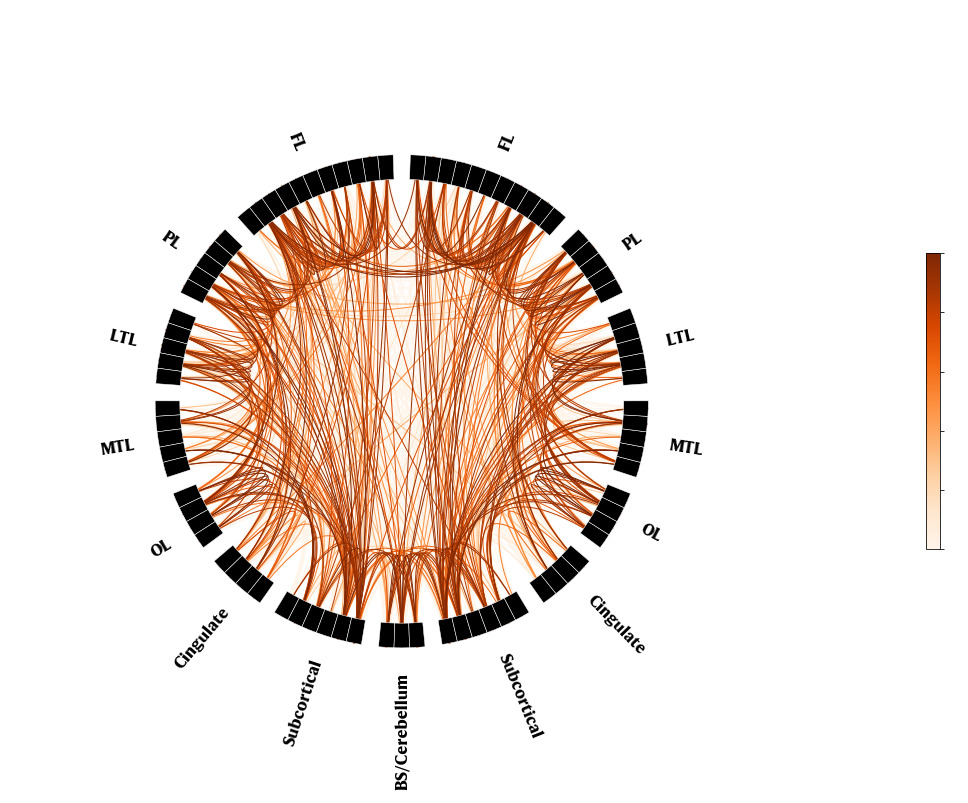

In [18]:
# Loop over bins with Desikan-Killiany atlas
dk_bins = ['0-0.25']

for b in dk_bins:
    # Select which age bin to visualize
    selected_bin = b

    # Get the frequency matrix for the selected bin
    freq_matrix = freq_mat[selected_bin]
    
    # Order regions by broader label groups: FL, PL, LTL, MTL, OL, Cingulate, Subcortical, BS/Cerebellum
    # Split into left hemisphere, bottom (BS/Cerebellum), and right hemisphere (reversed)
    broad_label_order = ["FL", "PL", "LTL", "MTL", "OL", "Cingulate", "Subcortical"]
    
    left_ordered = []
    right_ordered = []
    
    for broad_label in broad_label_order:
        idxs = broad_labels_dk_idxs[broad_label]
        # Split into left and right
        left = [i for i in idxs if i in left_idxs_dk]
        right = [i for i in idxs if i in right_idxs_dk]
        
        # Accumulate by hemisphere
        left_ordered.extend(left)
        right_ordered.extend(right)
    
    # Use the pre-ordered bottom_idxs_dk which has correct ordering: left cereb, brainstem, right cereb
    bottom_ordered = bottom_idxs_dk
    
    # Create final order: left hemisphere + bottom + right hemisphere (reversed)
    order = left_ordered + bottom_ordered + right_ordered[::-1]
    
    # Verify bottom ordering: left cerebellum, brainstem, right cerebellum
    bottom_names = [dk_names[i] for i in bottom_ordered]
    print(f"Bottom region order ({len(bottom_names)} regions):")
    for i, name in enumerate(bottom_names):
        print(f"  {i}: {name}")
    
    # Assert proper ordering
    left_cereb_count = len([n for n in bottom_names if 'left' in n.lower() and 'cerebellum' in n.lower()])
    right_cereb_count = len([n for n in bottom_names if 'right' in n.lower() and 'cerebellum' in n.lower()])
    brainstem_count = len([n for n in bottom_names if 'brainstem' in n.lower()])
    
    # Check that left cerebellum comes first, then brainstem, then right cerebellum
    if left_cereb_count > 0:
        assert all('left' in bottom_names[i].lower() for i in range(left_cereb_count)), "Left cerebellum not at start"
    if brainstem_count > 0:
        assert all('brainstem' in bottom_names[i].lower() for i in range(left_cereb_count, left_cereb_count + brainstem_count)), "Brainstem not in middle"
    if right_cereb_count > 0:
        assert all('right' in bottom_names[i].lower() for i in range(left_cereb_count + brainstem_count, len(bottom_names))), "Right cerebellum not at end"
    
    # Reorder connectivity matrix and labels
    conn = freq_matrix[np.ix_(order, order)]
    node_names = [dk_names[i] for i in order]

    # Count the amount of nodes that have values over 90%
    high_value_count = np.sum(conn > 90)
    print(f"Number of connections over 90% in age bin {selected_bin}: {high_value_count}")

    # Create a mapping from each node to its broader label using the broad_labels_dk dictionary
    node_to_broad_label = {}
    for i, name in enumerate(dk_names):
        for broad_label, patterns in broad_labels_dk.items():
            for pattern in patterns:
                if re.match(pattern.replace("*", ".*"), name):
                    node_to_broad_label[name] = broad_label
                    break
            if name in node_to_broad_label:
                break

    # Assign black color to all nodes
    node_colors = ["black" for _ in order]
    
    print(f"Assigned {len(set(node_colors))} unique color to {len(order)} nodes")

    # Find boundaries between different broader label groups for padding
    broad_label_boundaries = [0]
    group_labels = []
    group_ranges = []
    current_broad_label = None
    start_idx = 0

    for i, name in enumerate(node_names):
        broad_label = node_to_broad_label.get(name, None)
        if broad_label != current_broad_label:
            if i > 0:
                broad_label_boundaries.append(i)
                # Save the previous group
                group_labels.append(current_broad_label)
                group_ranges.append((start_idx, i))
            current_broad_label = broad_label
            start_idx = i

    # Don't forget the last group
    if current_broad_label is not None:
        group_labels.append(current_broad_label)
        group_ranges.append((start_idx, len(node_names)))

    print(f"Number of broader label groups: {len(group_labels)}")
    print(f"Groups: {group_labels}")

    # Compute node angles for circular layout with padding between broader label groups
    node_angles = circular_layout(node_names, node_names, 
                                start_pos=90, start_between=True, 
                                group_boundaries=broad_label_boundaries,
                                group_sep=4)  # Add 4 degrees padding between each broader label group

    # Create the chord diagram with larger circle
    fig, ax = plt.subplots(figsize=(14, 14), facecolor="white", subplot_kw=dict(polar=True))

    # Set radial limits to make circle larger
    ax.set_ylim(0, 10)

    plot_connectivity_circle(conn, node_names,
                            node_angles=node_angles,
                            node_colors=node_colors,
                            colormap="Oranges",  # Color scheme for connections
                            facecolor="white",
                            textcolor="white",
                            linewidth=1,
                            n_lines=high_value_count,
                            node_linewidth=0.5,
                            node_edgecolor="white",
                            fontsize_names=0,
                            vmin=90,
                            vmax=conn.max(),
                            colorbar_size=0.3,
                            colorbar_pos=(0.6, 0.5),
                            ax=ax,
                            show=False)

    # Add broader group labels pointing outwards
    for label, (start, end) in zip(group_labels, group_ranges):
        # Calculate the middle angle for this group
        middle_idx = (start + end) // 2
        angle = node_angles[middle_idx]
        
        # Convert angle to radians
        angle_rad = np.deg2rad(angle)
        
        # Position text outside the circle
        radius = 11
        
        # Determine text rotation and alignment for outward-pointing labels
        rotation = angle
        if 90 < angle < 270:
            # Bottom half - rotate 180 degrees so text reads outward
            rotation = angle - 180
            ha = 'right'
        else:
            # Top half - keep as is
            ha = 'left'
        
        ax.text(angle_rad, radius, label, 
                rotation=rotation, rotation_mode='anchor',
                ha=ha, va='center_baseline', fontsize=16, fontweight='bold')

    # Remove tick marks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    fig.savefig(RESULTS_DIR + f"chord_chart_desikan_killiany_{selected_bin.replace('-', '_')}.png", 
                dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')
